# Importing libraries

In [1]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import pickle
import os
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer
from sklearn.cross_validation import train_test_split
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load pickle files

In [2]:
ans_pairs = pickle.load(open("./pairs","rb"))    #reference answer and student answer
labels = pickle.load(open("./labels","rb"))      #correct or incorrect are the labels

In [3]:
print(len(labels))   # number of labels
print(len(ans_pairs)) #number of question pairs
print(len(list(set(labels))))

4969
4969
2


In [4]:
correctans_pair=[]
incorrectans_pair = []
poslabels = []
neglabels = []
reference = ans_pairs[0][0]
for i in range(len(labels)):
    if labels[i]==1:
        correctans_pair.append(ans_pairs[i])
        poslabels.append(labels[i])
    else:
        incorrectans_pair.append(ans_pairs[i])
        neglabels.append(labels[i])
print(len(correctans_pair),len(poslabels))
print(len(incorrectans_pair),len(neglabels))

2008 2008
2961 2961


In [5]:
anchor_pair = []
correct_answer_pair = []
wrong_answer = []
trainlabels = []
k=1
for i in correctans_pair:
    print(k)
    for j in incorrectans_pair:
        if i[0] in j[0]:
            anchor_pair.append(i[0])
            correct_answer_pair.append(i[1])
            wrong_answer.append(j[1])
            trainlabels.append(1)
        else:
            continue
    k=k+1
print(len(anchor_pair),len(correct_answer_pair),len(wrong_answer))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
36735 36735 36735


In [7]:
refanswer_list = []
stuanswer_list = []
#stuneganswer_list = []
for i in ans_pairs:
    refanswer_list.append(i[0])
    stuanswer_list.append(i[1])
print(len(refanswer_list),len(stuanswer_list))

4969 4969


In [8]:
BASE_DIR = './glove.6B/'
max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
MAX_SEQUENCE_LENGTH = 20

EMBEDDING_DIM = 100

embeddings_index = {}
f = open(os.path.join(BASE_DIR, 'glove.6B.100d.txt'),encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word.lower()] = coefs
f.close()

word_cindex={}
c=0
for word in embeddings_index:
    word_cindex[word]=c
    c+=1

In [9]:
nb_words=len(set(word_cindex))
embedding_matrix = np.zeros((nb_words + 1, EMBEDDING_DIM))
for word, i in word_cindex.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        if embedding_vector.shape[0]<EMBEDDING_DIM:
            embedding_vector=np.hstack([embedding_vector,[0]])
    # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [10]:
def text_to_vector(answerlist):
    vocab = {}
    for line in answerlist:
        a=line.split()
        for i in a:
            if i in vocab:
                vocab[i]+=1
            else:
                vocab[i]=1
    nb_words = len(vocab)
    MAX_NB_WORDS=nb_words
    tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(answerlist)
    sequences = tokenizer.texts_to_sequences(answerlist)
    word_index = tokenizer.word_index
    return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [11]:
reference_features = text_to_vector(refanswer_list)
reference_features = pd.DataFrame(reference_features)
print(reference_features.shape)
stuanswer_features = text_to_vector(stuanswer_list)
stuanswer_features = pd.DataFrame(stuanswer_features)
print(stuanswer_features.shape)

/usr/local/lib/python3.5/dist-packages/keras/preprocessing/text.py:157: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


(4969, 20)
(4969, 20)


In [13]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = \
    train_test_split(reference_features, 
                     stuanswer_features,
                     labels,
                     test_size=0.2)

In [14]:
print(X1_train.shape)    # Reference answer training data
print(X1_val.shape)      # Reference answer validation data
print(X2_train.shape)    # Student answer training data
print(X2_val.shape)      # student answer validation data
#print(X3_train.shape)    
print(len(y_train))      # labels in training
print(len(y_val))       # labels in testing

(3975, 20)
(994, 20)
(3975, 20)
(994, 20)
3975
994


In [21]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 10
n_epoch = 10

In [16]:
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

In [17]:
ALPHA = 0.2  # Triplet Loss Parameter
def triplet_loss(x):
    anchor, positive, negative = x

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)
    print(pos_dist,neg_dist,pos_dist-neg_dist)
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), ALPHA)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)

    return loss

In [18]:
# The visible layer
left_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
right_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
#anchor_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

In [54]:
embedding_layer = Embedding(nb_words + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)
#encoded_anchor = embedding_layer(anchor_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

#anchor_output = shared_lstm(encoded_anchor)
left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

restlstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])
# Calculates the distance as defined by the MaLSTM model
#restlstm_distance = Merge(mode=exponent_neg_manhattan_distance, output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
restlstm = Model([left_input, right_input], [restlstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

restlstm.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

/home/adithya/.local/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [55]:
# Start training
training_start_time = time()

restlstm_trained = restlstm.fit([X1_train, X2_train], np.array(y_train), batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X1_val, X2_val], np.array(y_val)))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Train on 3975 samples, validate on 994 samples
Epoch 1/10
3975/3975 [==============================] - 362s 91ms/step - loss: 0.8790 - acc: 0.6189 - val_loss: 0.6532 - val_acc: 0.6207
Epoch 2/10
3975/3975 [==============================] - 346s 87ms/step - loss: 0.5704 - acc: 0.7072 - val_loss: 0.6275 - val_acc: 0.6539
Epoch 3/10
3975/3975 [==============================] - 326s 82ms/step - loss: 0.5218 - acc: 0.7527 - val_loss: 0.6150 - val_acc: 0.6610
Epoch 4/10
3975/3975 [==============================] - 358s 90ms/step - loss: 0.4884 - acc: 0.7826 - val_loss: 0.6155 - val_acc: 0.6640
Epoch 5/10
3975/3975 [==============================] - 342s 86ms/step - loss: 0.4618 - acc: 0.8103 - val_loss: 0.6073 - val_acc: 0.6841
Epoch 6/10
3975/3975 [==============================] - 341s 86ms/step - loss: 0.4396 - acc: 0.8221 - val_loss: 0.6113 - val_acc: 0.6710
Epoch 7/10
3975/3975 [==============================] - 339s 85ms/step - loss: 0.4184 - acc: 0.8390 - val_loss: 0.6116 - val_acc: 0

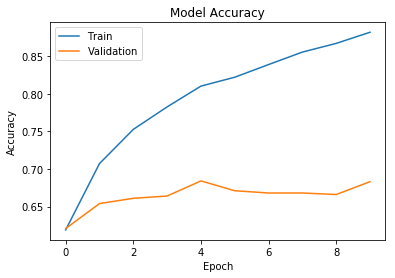

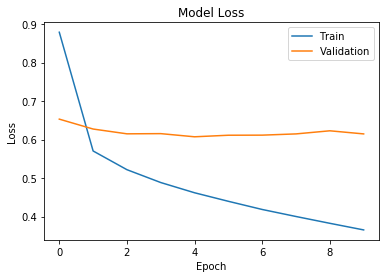

In [56]:
# Plot accuracy
plt.plot(restlstm_trained.history['acc'])
plt.plot(restlstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(restlstm_trained.history['loss'])
plt.plot(restlstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [58]:
Y_pred = restlstm_trained.model.predict([X1_val,X2_val])

In [63]:
import math
y_pred = []
for i in Y_pred:
    y_pred.append(int(np.round(i)))
    
print(y_pred[0:10])

[0, 0, 0, 1, 0, 1, 0, 0, 1, 1]


In [61]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_val,y_pred))
print(confusion_matrix(y_val,y_pred))

             precision    recall  f1-score   support

          0       0.66      0.90      0.76       553
          1       0.77      0.41      0.53       441

avg / total       0.71      0.68      0.66       994

[[498  55]
 [260 181]]


In [49]:
X2_val[0:10]

array([[   0,    0,    0,    4,    1,   40, 1068,   94,    6,  291,   67,
           7, 1146,    7,    1,   95,    4,    2,    3,  123],
       [   0,   65,   15,   19,   12,  105,   47,    4,    1,  105,   47,
           3,  419,  110,    5,    1,  842,    3,  497,  110],
       [  96,   24,    3,  396,   61,   41,    6,   67,  140,    6,  403,
         443,    4,    1,   24,   10,  206,    6,  249,   98],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    4,    8,    1,   81],
       [ 109,    5,    9,    3,  170, 1483,    7,   38,   40,    5,   28,
           2,    3,   12,  450,    2,    3,   12,  197,   40],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,   15,   10,  316,   22, 1533],
       [   0,    0,    0,   71,   21,  577,    9,    1,   24,    3,   12,
         180, 1233,    4,    6,  217,  236,    2,   46,  180],
       [   0,    0,    0,    0,    0,    

In [17]:
import pickle
import pandas as pd
file2 = open('/home/adithya/data_dump','rb')
goldlabels = pd.read_csv('./semeval2013-Task7-challenge-setup/gold/seb-2way-test-gold.txt',sep='\t')
data_dump2 = pickle.load(file2)
file2.close()
testlabels = []
reftest_pairs = []
stutest_pairs = []
for i in data_dump2:
    print(i[0]) # {questionid : question}
    print(i[1]) # {ref_ans_id : ref_snswer}
    for j in i[2]:
        temp = []
        #print(j) # student answer id
        #print(i[2][j][0], i[2][j][1]) # accurcy, student answer
        reftest_pairs.append(list(i[1].values())[0])
        #print(list(i[1].values())[0])
        stutest_pairs.append(i[2][j][1])
        testlabels.append(i[2][j][0])

{'SE_46': "Amber predicted that a black covered box would heat up faster than a white covered box. She took 2 identical shoe boxes and wrapped one with white paper and the other with black paper. She punched a hole in each box, stuck a thermometer into each hole, and put both boxes in the sun. Every 5 minutes, Amber recorded the temperature in each box. Will the data support Amber's prediction? Explain your answer."}
{'SE_46-a1': 'Yes. Black absorbs more heat (energy) than white. White reflects more heat (energy) than black. Therefore the black covered box will heat up faster than the white covered box.'}
{'VB_29': 'When conducting a controlled experiment, why do you use a standard?'}
{'VB_29-a1': 'A standard is used for comparison to determine how changing one variable changes the results.'}
{'EM_47': 'The sand and flour in the gray material from mock rocks is separated by mixing with water and allowing the mixture to settle. Explain why the sand and flour separate.'}
{'EM_47-a1': 'Th

In [18]:
print(len(stutest_pairs))

4969


In [19]:
restlstm.save_weights("siamese-l2loss-lstmmodel.h5")
print("Saved model to disk")

NameError: name 'restlstm' is not defined